# [使用 圖譜資料庫 建立 QA 應用程式](https://python.langchain.com/v0.2/docs/tutorials/graph/)

在本指南中，我們將介紹如何在圖形資料庫上建立問答鏈的基本方法。這些系統將允許我們針對圖形資料庫中的數據提出問題，並以自然語言的形式獲得答案。

## ⚠️ 安全提醒 ⚠️

構建圖形資料庫的問答系統需要執行由模型生成的圖形查詢。這其中存在一定的風險。請確保您的資料庫連線權限範圍盡可能縮小，以滿足您鏈條/代理人的需求。這樣可以減少，但無法完全消除，構建模型驅動系統的風險。關於一般的安全最佳實踐，請參閱[這裡](/docs/security)。

## 架構

從高層次來看，大多數圖形鏈的步驟如下：

1. **將問題轉換為圖形資料庫查詢**：模型將使用者輸入轉換為圖形資料庫查詢（例如 Cypher）。
2. **執行圖形資料庫查詢**：執行圖形資料庫查詢。
3. **回答問題**：模型使用查詢結果回應使用者輸入。

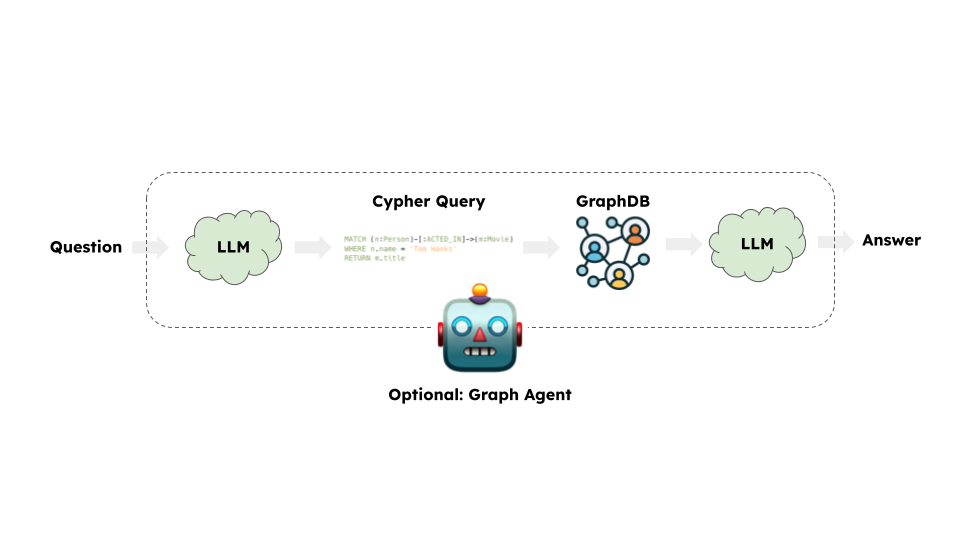

## 設置

首先，取得所需的套件並設置環境變數。
在此範例中，我們將使用 Neo4j 圖形資料庫。

In [ ]:
# ! pip3 install --upgrade langchain langchain-community langchain-openai neo4j

預設使用 OpenAI模型

In [1]:
import getpass
import os

# os.environ["OPENAI_API_KEY"] = getpass.getpass()

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

 ········


接下來，我們需要定義 Neo4j 的認證資訊。
請按照[這些安裝步驟](https://neo4j.com/docs/operations-manual/current/installation/)來設置 Neo4j 資料庫。

In [1]:
import os
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "2wsx3edc"

您還必須額外安裝 Neo4j APOC 插件來支援 LangChain
[在這裡](https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases/) 找到最新版本

下載二進制 jar 檔，並將其放入 $NEO4J_HOME/plugins 資料夾中。

以下範例將建立與 Neo4j 資料庫的連線，並使用有關電影及其演員的範例數據來填充資料庫。

In [4]:
from langchain_community.graphs import Neo4jGraph

database = os.environ.get('NEO4J_DATABASE')
graph = Neo4jGraph(database=database)

# Import movie information
graph.query('MATCH (n) DETACH DELETE n;')

movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

## 圖形結構

為了讓大型語言模型（LLM）能夠生成 Cypher 語句，它需要了解圖形結構的相關資訊。當您實例化一個圖形對象時，系統會自動檢索圖形結構的資訊。如果您之後對圖形進行了任何更改，可以執行 `refresh_schema` 方法來刷新結構資訊。

In [5]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Movie {title: STRING, imdbRating: FLOAT, id: STRING, released: DATE}
Person {name: STRING}
Genre {name: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


太好了！我們已經有一個可以查詢的圖形資料庫。現在，讓我們試著將它連接到一個大型語言模型（LLM）。

## Chain

我們來使用一個簡單的鏈條，它接收一個問題，將其轉換為 Cypher 查詢，執行該查詢，然後使用結果來回答原始問題。

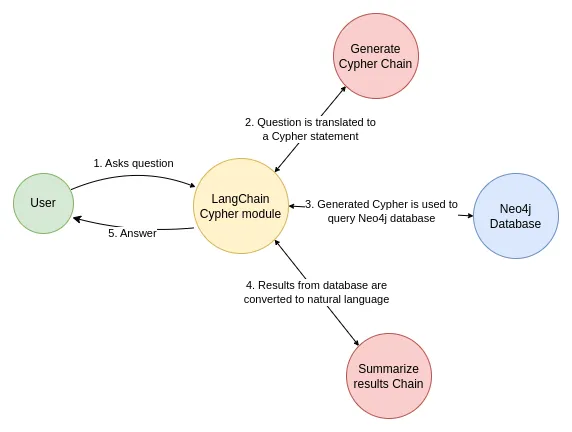

LangChain 提供了一個內建的Chain來處理這個工作流程，並設計用於與 Neo4j 配合使用：[GraphCypherQAChain](/docs/integrations/graphs/neo4j_cypher)

In [6]:
from langchain.chains import GraphCypherQAChain
# from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)
chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True)
response = chain.invoke({"query": "What was the cast of the Casino?"}) # 《賭城風雲》（Casino）的演員陣容有哪些？
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Movie {title: "Casino"})<-[:ACTED_IN]-(p:Person)
RETURN p.name

Full Context:
[{'p.name': 'James Woods'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Robert De Niro'}, {'p.name': 'Sharon Stone'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'James Woods, Joe Pesci, Robert De Niro, and Sharon Stone were the cast of Casino.'}

# 驗證關係方向

大型語言模型（LLMs）在生成 Cypher 語句時，可能會對關係的方向感到困難。由於圖形結構是預先定義的，我們可以透過使用 `validate_cypher` 參數來驗證並選擇性地修正生成的 Cypher 語句中的關係方向。

In [14]:
chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, verbose=True, validate_cypher=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: "Casino"})
RETURN p.name

Full Context:
[{'p.name': 'James Woods'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Robert De Niro'}, {'p.name': 'Sharon Stone'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'James Woods, Joe Pesci, Robert De Niro, and Sharon Stone were part of the cast of Casino.'}

### 下一步

對於更複雜的查詢生成，我們可能需要創建 few-shot 提示或添加查詢檢查步驟。要了解這些進階技巧及更多相關內容，請參閱以下資源：

* [提示策略](https://python.langchain.com/v0.2/docs/how_to/graph_prompting)：進階的提示工程技術。
* [映射數值](https://python.langchain.com/v0.2/docs/how_to/graph_mapping)：從問題中將數值映射到資料庫的技術。
* [語義層](https://python.langchain.com/v0.2/docs/how_to/graph_semantic)：實現語義層的技術。
* [構建圖形](https://python.langchain.com/v0.2/docs/how_to/graph_constructing/)：構建知識圖譜的技術。